In [23]:
from cgisim_sims import cgisim_sims
import matplotlib.pylab as plt
import proper
import roman_phasec_proper
import numpy as np
import astropy.io.fits as pyfits
from scipy.ndimage import rotate

### Add point source companion to simulated image with CGISim_sims:

In [24]:
cgisim_obj = cgisim_sims()

# Set DM solutions
dm1 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '/examples/hlc_best_contrast_dm1.fits')
dm2 = proper.prop_fits_read( roman_phasec_proper.lib_dir + '/examples/hlc_best_contrast_dm2.fits')
cgisim_obj.options['dm1'] = dm1
cgisim_obj.options['dm2'] = dm2

In [6]:
name_scene = 'example_pointsourcecompanions_rollsAndRefv6'
flag_use_emccd = False

### Set up sources in image:
cgisim_sims object has a sources attribute, which holds information for the target star, reference star, and companions:
- [0]: science target star (source 1)
- [1]: reference star (source 2)
- [2]: planet (source 3)

Each source can take a name, a spectral type, and a V$_{mag}$. Spectral types are read from pre-existing CGISim files. The name field is optional.

In [7]:
# Science target star
star_vmag = 5.04
cgisim_obj.sources[0]['star_vmag'] = star_vmag
cgisim_obj.sources[0]['star_type'] = 'g0v'
cgisim_obj.sources[0]['name'] = '47Uma'

# Reference star
starref_vmag = 5.04
cgisim_obj.sources[1]['star_vmag'] = starref_vmag
cgisim_obj.sources[1]['star_type'] = 'g0v'
cgisim_obj.sources[1]['name'] = 'rPup'

# Planet
starref_vmag = star_vmag + 8*2.5 # * 2.5 to calculate magnitude increase relative to host star ?
cgisim_obj.sources[2]['star_vmag'] = starref_vmag
cgisim_obj.sources[2]['star_type'] = 'g0v'
cgisim_obj.sources[2]['name'] = '47Umab'

#### Read in the jitter and Z4-11 time series from OS11 files
More about these in the OS11 slide deck from J. Krist (slide 18):
- Z4-Z11: LOWFS-derived low order corrections
- X & Y post-FSM pointing jitter

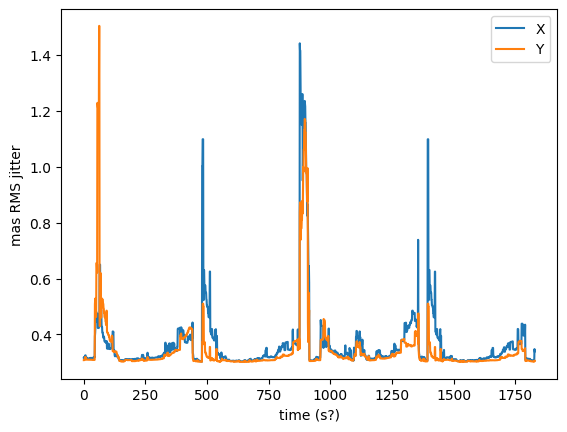

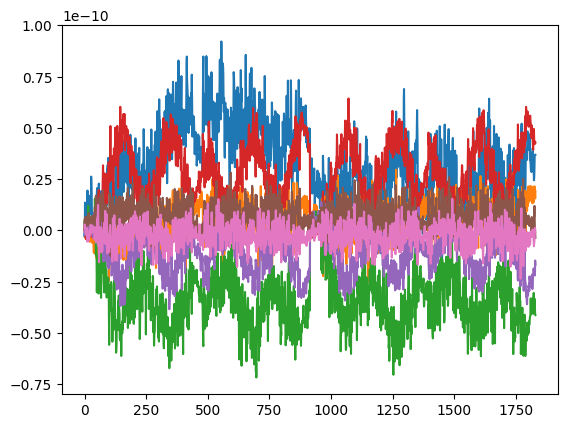

In [8]:
datadir_Z411 = "/Users/sammyh/Codes/cgisim_sims/data/hlc_os11_v2/" # "../cgisim_sims/data/hlc_os11_v2/"
flnm_Z411 = "hlc_os11_inputs.fits"
inFile = pyfits.open(datadir_Z411+flnm_Z411)
hlc_os11_inputs = inFile[0].data

# Retrieve jitter values
jitt_sig_x_arr = hlc_os11_inputs[:,78] * 1 # [masRMS]
jitt_sig_y_arr = hlc_os11_inputs[:,79] * 1 # [masRMS]

# Take a look at the jitter
plt.figure(111)
plt.plot(jitt_sig_x_arr, label='X')
plt.plot(jitt_sig_y_arr, label='Y')
plt.ylabel('mas RMS jitter')
plt.xlabel('time (s?)')
plt.legend()

# Retrieve Z4-Z11 values
z411_mat = hlc_os11_inputs[:,46:54]
# look at Z4-Z11 
plt.figure(112)
for i in range(11-4):
    plt.plot(z411_mat[:,i])

## After reading in jitter, create a scene:
1. Define the batches for the observation (batch = sequence of telescope pointing and taking images)
    For example:
     - Batch 1: image reference star
     - Batch 2: image target star
2. Define the roll ID, exposure time
3. Define a point source companion 

In [9]:
# Batch IDs -- for naming
batch_id_os11 = hlc_os11_inputs[:,2]

# Create scene with LO errors
cgisim_obj.generate_scene(name=name_scene,jitter_x=jitt_sig_x_arr,jitter_y=jitt_sig_y_arr,
                          zindex=np.arange(4,11+1),zval_m=z411_mat)

# Initialize schedule_index_array
cgisim_obj.scene['schedule']['schedule_index_array'] = []

#### Reference target observation:

In [10]:
index_batch_ref = 0
batch_ID = 0
num_frames_ref = len(np.where(batch_id_os11==batch_ID)[0])
sourceid_ref = 1 # choose the star
V3PA = 0         # roll angle
exptime = 30     
cgisim_obj.scene['schedule']['batches'][0] = {'num_timesteps':num_frames_ref,
                                                 'batch_ID':batch_ID,
                                                 'sourceid':sourceid_ref,
                                                 'exptime':exptime,
                                                 'V3PA':V3PA}
cgisim_obj.scene['schedule']['schedule_index_array'].append(np.ones(num_frames_ref)*index_batch_ref)

#### Science observation Roll 1:

In [11]:
index_batch_roll1 = 1
batch_ID = 100
num_frames_roll1 = len(np.where(batch_id_os11==batch_ID)[0])
sourceid_sci = 0    # choose source star
V3PA_roll1 = 13     # roll angle
exptime = 30
cgisim_obj.scene['schedule']['batches'].append({'num_timesteps':num_frames_roll1,
                                                 'batch_ID':batch_ID,
                                                 'sourceid':sourceid_sci,
                                                 'exptime':exptime,
                                                 'V3PA':V3PA_roll1})
cgisim_obj.scene['schedule']['schedule_index_array'].append(np.ones(num_frames_ref)*index_batch_roll1)


#### Science observation Roll 2:

In [12]:
index_batch_roll2 = 2
batch_ID = 101
# num_frames_roll2 = 3
num_frames_roll2 = len(np.where(batch_id_os11==batch_ID)[0])
sourceid_sci = 0 # what star?
V3PA_roll2 = -13 #roll angle
exptime = 30
cgisim_obj.scene['schedule']['batches'].append({'num_timesteps':num_frames_roll2,
                                                 'batch_ID':batch_ID,
                                                 'sourceid':sourceid_sci,
                                                 'exptime':exptime,
                                                 'V3PA':V3PA_roll2})
cgisim_obj.scene['schedule']['schedule_index_array'].append(np.ones(num_frames_ref)*index_batch_roll2)


#### Add point source companion:
- sourceid : ID of point source companion, defined above
- central_sourceid : ID of host star
- xoffset : x-direction offset from center for location of point source in mas
- yoffset : y_direction offset from center for location of point source in mas

In [13]:
cgisim_obj.add_point_source_to_scene(sourceid=2, central_sourceid=0, xoffset=200, yoffset=200)

#### Generate speckle series based on the scene defined above:
- num_images_printed : how many images to print out in plot
- flag_return_contrast : whether or not to return the contrast of the point source companion <span style="color:red">(TODO: CONFIRM DEFINITION)</span>
- use_emccd : whether or not to use emccd to add detector noise
- use_photoncount : whether or not to photon count (only with emccd)

This is going to run for awhile to generate the images.

In [14]:
cgisim_obj.generate_speckleSeries_from_scene(num_images_printed=0,flag_return_contrast=False,
                                             use_emccd=False,use_photoncount=False)

Starting the simulation of scene 'example_pointsourcecompanions_rollsAndRefv6'
Computing image num. 1 out of 45
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Reading in the jitter parameters and EFs into a cube
Computing image num. 2 out of 45
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 3 out of 45
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 4 out of 45
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 5 out of 45
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 6 out of 45
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes

Computing image num. 10 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 11 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 12 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 13 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 14 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 15 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 16 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to comp

Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 67 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 68 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 69 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 70 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 71 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 72 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 73 out of 99
Computi

Computing image num. 23 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 24 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 25 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 26 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 27 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 28 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.3 minutes.
Total time to compute =    0.3 minutes.
Computing image num. 29 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to comp

Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 80 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 81 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 82 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 83 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 84 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 85 out of 99
Computing fields 1 to 7 of 7
Time to compute 7 fields =    0.4 minutes.
Total time to compute =    0.4 minutes.
Computing image num. 86 out of 99
Computi

## Time for post-processing:
1. Read in fits files
2. Subtract reference 
3. Derotate images
4. Co-add images
5. Plot and save

In [17]:
# Get where images are located and set path for outputting images
datadir = cgisim_obj.scene['outdir']
outdir_images = datadir

# Get reference image
flnm = 'Ii_coadded_batch0.fits'
data = pyfits.open(datadir + flnm)
im_ref = data[0].data

# Get roll 1
flnm = 'Ii_coadded_batch100.fits'
data = pyfits.open(datadir + flnm)
im_roll1 = data[0].data

# Get roll 2
flnm = 'Ii_coadded_batch101.fits'
data = pyfits.open(datadir+flnm)
im_roll2 = data[0].data

In [18]:
# Subtract reference from rolls
im_sub1 = im_roll1 - im_ref
im_sub2 = im_roll2 - im_ref

# Derotate
im1 = rotate(im_sub1, V3PA_roll1)
im2 = rotate(im_sub2, V3PA_roll2)

# Co-add
im_final = (im1 + im2) / 2

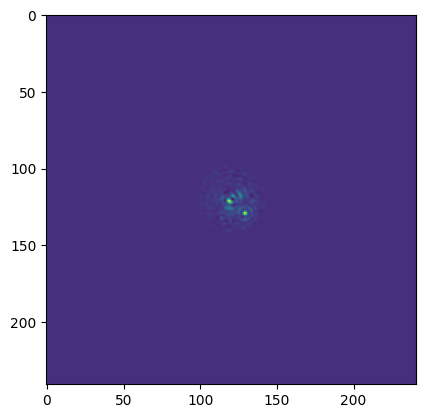

In [19]:
# Plot
plt.figure(112)
plt.imshow(im_final)

In [21]:
# Save image
hdulist = pyfits.PrimaryHDU(im_final)
hdulist.writeto(outdir_images + 'im_roll_subtracted_example.fits', overwrite=True)